<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/yf%20%20finanace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [2]:
# Calculate the date 730 days ago
end_date = datetime.now()
start_date = end_date - timedelta(days=729)

# Download the data
data = yf.download('EURUSD=X', start=start_date, end=end_date, interval='1h')

# Print the data
print(data)

[*********************100%%**********************]  1 of 1 completed
                               Open      High       Low     Close  Adj Close  \
Datetime                                                                       
2021-10-18 07:00:00+01:00  1.157943  1.158346  1.157675  1.158212   1.158212   
2021-10-18 08:00:00+01:00  1.157943  1.159958  1.157943  1.159689   1.159689   
2021-10-18 09:00:00+01:00  1.159689  1.160093  1.158480  1.158480   1.158480   
2021-10-18 10:00:00+01:00  1.158614  1.159152  1.158078  1.158614   1.158614   
2021-10-18 11:00:00+01:00  1.158480  1.159958  1.158078  1.159555   1.159555   
...                             ...       ...       ...       ...        ...   
2023-10-16 15:00:00+01:00  1.053297  1.055743  1.052964  1.055186   1.055186   
2023-10-16 16:00:00+01:00  1.055186  1.055520  1.054519  1.054741   1.054741   
2023-10-16 17:00:00+01:00  1.054741  1.055075  1.054407  1.054964   1.054964   
2023-10-16 18:00:00+01:00  1.054964  1.055855  1.05

In [28]:
High = data['High'].to_numpy()
Close = data['Close'].to_numpy()
Low = data['Low'].to_numpy()
Std = np.std(np.diff(Close))
Close_Diff = np.diff(Close)/Std
High_Adj = (High[1:]-Close[1:])/Std
Low_Adj = (Close[1:]-Low[1:])/Std
# Get the sum of adjacent values
sum_array = Close_Diff[:-1] + Close_Diff[1:]
print(sum_array)

[ 0.21476253 -0.8602904   0.86009958 ... -0.17822141  0.89120246
  0.71317187]


In [4]:
stack = np.stack((Close_Diff, High_Adj, Low_Adj), axis=1)
print(stack)

[[ 1.18248189  0.21533497  1.39714901]
 [-0.96771937  1.29076953  0.        ]
 [ 0.10742897  0.43000209  0.42952505]
 ...
 [ 0.1780306   0.08911071  0.4451719 ]
 [ 0.71317187  0.          0.89120246]
 [ 0.          0.08920611  0.26752293]]


In [21]:
window_size = 50
window_view = np.lib.stride_tricks.sliding_window_view(stack, (window_size,),axis=0)

In [22]:
print(window_view[0])
input = window_view[:-1]
target = Close_Diff[window_size:]
print(target)

[[ 1.18248189 -0.96771937  0.10742897  0.75267062  0.64610032  0.43124239
  -0.43124239  0.1078106   0.86305722  0.6483901  -0.54038869 -0.21600282
   0.          0.10800141 -0.10800141 -0.107906    0.32390883  0.9731576
   0.75820426  0.54248766  0.32572157  0.10857386  0.21733853  0.10876467
   0.21743394  0.43524951  0.43572655 -0.43572655  0.         -1.08736051
   0.86973575 -1.08697888 -0.86763679  0.54210603  0.10847845 -0.10847845
  -0.2169569   0.         -0.21686149  0.10838304 -0.32505372  0.32505372
   0.54248766 -0.32562617  0.54267847  0.54334633 -0.3261032  -0.65134774
  -1.19192724  0.10828763]
 [ 0.21533497  1.29076953  0.43000209  0.32295475  0.          0.53962543
   0.97086782  0.75505581  0.          0.32448127  0.75677315  0.43210106
   0.32400424  0.32409964  0.43210106  0.43191024  0.32419505  0.
   0.21686149  0.          0.10857386  0.86992657  0.65258804  0.43505869
   0.21762475  0.          0.21791098  0.87183472  0.43572655  1.08736051
   0.21762475  1.304

In [23]:
model = Sequential()
model.add(LSTM(units=10, activation='gelu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(LSTM(units=10, activation='gelu', return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(units=10, activation='gelu'))
model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(units=1, activation=None))

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
model.fit(input, target, epochs=20000, batch_size=64,validation_split=.2)

Epoch 1/20000
155/155 [==============================] - 5s 8ms/step - loss: 2.5338 - val_loss: 0.5883
Epoch 2/20000
155/155 [==============================] - 1s 7ms/step - loss: 1.6851 - val_loss: 0.5875
Epoch 3/20000
155/155 [==============================] - 1s 7ms/step - loss: 1.4369 - val_loss: 0.5888
Epoch 4/20000
155/155 [==============================] - 1s 6ms/step - loss: 1.3535 - val_loss: 0.5850
Epoch 5/20000
155/155 [==============================] - 1s 6ms/step - loss: 1.2773 - val_loss: 0.5853
Epoch 6/20000
155/155 [==============================] - 1s 6ms/step - loss: 1.2097 - val_loss: 0.5846
Epoch 7/20000
155/155 [==============================] - 1s 6ms/step - loss: 1.1829 - val_loss: 0.5844
Epoch 8/20000
155/155 [==============================] - 1s 6ms/step - loss: 1.1537 - val_loss: 0.5845
Epoch 9/20000
155/155 [==============================] - 1s 6ms/step - loss: 1.1445 - val_loss: 0.5845
Epoch 10/20000
155/155 [==============================] - 1s 6ms/step - l

KeyboardInterrupt: ignored

In [26]:
predictions = model.predict(input)

386/386 [==============================] - 1s 1ms/step


(-2.0, 2.0)

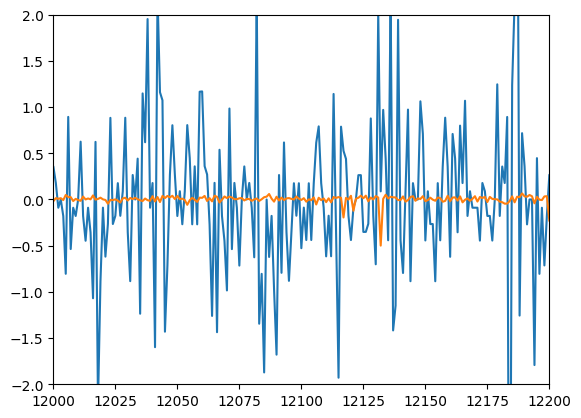

In [27]:

plt.plot(target)
plt.plot(predictions)
plt.xlim(12000,12200)
plt.ylim(-2,2)

In [ ]:
plt.plot(Low_Adj)

In [ ]:
def Adj_Data(DataFrame):
  High = data['High'].to_numpy()
  Close = data['Close'].to_numpy()
  Low = data['Low'].to_numpy()
  Std = np.std(np.diff(Close))
  Close_Diff = np.diff(Close)/Std
  High_Adj = (High[1:]-Close[1:])/Std
  Low_Adj = (Close[1:]-Low[1:])/Std